# Create a confusion matrix

Demonstrates image pre-processing, prediction and validation statistics. But first, some preliminaries...

__Note:__ To maintain a high priority Colab user status such that sufficient GPU resources are available in the future, ensure to free the runtime when finished running this notebook. This can be done using 'Runtime > Manage Sessions' and click 'Terminate'.

In [1]:
# Check if notebook is running in Colab or local workstation
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
    !pip install gputil
    !pip install psutil
    !pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

try:
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[1]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm() 

    # Check if GPU capacity is sufficient to proceed
    if gpu.memoryFree < 10000:
        print("\nInsufficient memory! Some cells may fail. Please try restarting the runtime using 'Runtime → Restart Runtime...' from the menu bar. If that doesn't work, terminate this session and try again later.")
    else:
        print('\nGPU memory is sufficient to proceeed.')
except:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')

Gen RAM Free: 62.3 GB  | Proc size: 54.2 MB
GPU RAM Free: 11176MB | Used: 2MB | Util   0% | Total 11178MB

GPU memory is sufficient to proceeed.


In [2]:
if IN_COLAB:

    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    
    # cd into git repo so python can find utils
    %cd '/content/drive/My Drive/cciw-zebra-mussel/predict'

    sys.path.append('/content/drive/My Drive')
    
    # clone repo, install packages not installed by default
    !pip install pydensecrf

In [3]:
import os
import os.path as osp

import glob

# for manually reading high resolution images
import cv2
import numpy as np

# for comparing predictions to lab analysis data frames
import pandas as pd

# for plotting
import matplotlib
# enable LaTeX style fonts
matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# pytorch core library
import torch
# pytorch neural network functions
from torch import nn
# pytorch dataloader
from torch.utils.data import DataLoader

# for post-processing model predictions by conditional random field 
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

from tqdm import tqdm  # progress bar

# evaluation metrics
from sklearn.metrics import r2_score
from sklearn.metrics import jaccard_score as jsc

# local imports (files provided by this repo)
import transforms as T

# various helper functions, metrics that can be evaluated on the GPU
from task_3_utils import evaluate, evaluate_loss, eval_binary_iou, pretty_image

# Custom dataloader for rapidly loading images from a single LMDB file
from folder2lmdb import VOCSegmentationLMDB

In [4]:
"""Confim that this cell prints "Found GPU, cuda". If not, select "GPU" as 
"Hardware Accelerator" under the "Runtime" tab of the main menu.
"""
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Found GPU,', device)

Found GPU, cuda


## 1. Load a pre-trained model checkpoint

The architecture is fully-convolutional network (FCN) 8s.

In [5]:
from fcn import FCN8s
net = FCN8s(n_class=1).to(device)

In [6]:
from apex import amp
net = amp.initialize(net, opt_level='O3')

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0


In [7]:
if IN_COLAB:
    root = osp.join(DATA_PATH, 'Checkpoints/fcn8slim_lr1e-03_wd5e-04_bs32_ep50_seed1')
else:
    root = '/scratch/gallowaa/cciw/logs/v1.0.1-debug/fcn8s/lr1e-03/wd5e-04/bs25/ep80/seed4/checkpoint' # b
    #root = '/scratch/gallowaa/cciw/logs/v111/trainval/fcn8s/lr1e-03/wd5e-04/bs40/ep80/seed2/checkpoint/' # d

ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed4_epoch70.ckpt' # b
#ckpt_file = 'fcn8s_lr1e-03_wd5e-04_bs40_ep80_seed2amp_epoch79.pt' # d

"""Feel free to try these other checkpoints later after running epoch40 to get a 
feel for how the evaluation metrics change when model isn't trained as long."""

checkpoint = torch.load(osp.join(root, ckpt_file))
train_loss = checkpoint['trn_loss']
val_loss = checkpoint['val_loss']
last_epoch = checkpoint['epoch'] + 1
torch.set_rng_state(checkpoint['rng_state'])
print('==> Resuming from checkpoint..')

net = checkpoint['net']
'''
# AMP
net.load_state_dict(checkpoint['net'])
amp.load_state_dict(checkpoint['amp'])
'''
# later appended to figure filenames
model_stem = ckpt_file.split('.')[0]

print('Loaded model %s trained to epoch ' % model_stem, last_epoch)
print('Cross-entropy loss {:.4f} for train set, {:.4f} for validation set'.format(train_loss, val_loss))

==> Resuming from checkpoint..
Loaded model fcn8s_lr1e-03_wd5e-04_bs25_ep80_seed4_epoch70 trained to epoch  71
Cross-entropy loss 0.5821 for train set, 0.5709 for validation set


In [8]:
#net = amp.initialize(net, opt_level='O3')

In [9]:
sig = nn.Sigmoid()  # initializes a sigmoid function

## 7. i) Visualize Predictions on Whole Images

Here we manually load and preprocess the original images and png masks using OpenCV.

`root_path` -- will also be used in 

In [10]:
if IN_COLAB:
    root_path = osp.join(DATA_PATH, 'ADIG_Labelled_Dataset/Test/Lab/')
else:
    #root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Lab/done/'
    #root_path = '/scratch/ssd/gallowaa/cciw/VOCdevkit/Validation-v101-originals/'
    root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Train/2018-06/land/'
    #root_path = '/scratch/ssd/gallowaa/cciw/dataset_raw/Test/Tripod/1352/'

jpeg_files = glob.glob(root_path + '*.jpg')
png_files = glob.glob(root_path + '*crop.png')
#png_files = glob.glob(root_path + '*_final.png')

# in-situ
#jpeg_files = glob.glob(osp.join(root_path, 'JPEGImages/') + '*.jpg')
#png_files = glob.glob(osp.join(root_path, 'SegmentationClass/') + '*_crop.png')

jpeg_files.sort()
png_files.sort()

# Both should equal 36 for v1.0.0 Lab dataset
print(len(jpeg_files)) 
print(len(png_files))

13
13


In [11]:
jpeg_files = ['GLNI_2909-1_2018-06-28_image-1_crop.jpg']
png_files  = ['GLNI_2909-1_2018-06-28_image-1_crop_gimp_final.png']

In [12]:
"""Set to True to save the model predictions in PNG format, 
otherwise proceed to predict biomass without saving images"""
SAVE_PREDICTIONS = False

if SAVE_PREDICTIONS:
    prediction_path = ''
    for t in root.split('/')[:-1]:
        prediction_path += t + '/'

    prediction_path = osp.join(prediction_path, 'predictions')

    if not osp.exists(prediction_path):
        os.mkdir(prediction_path)

    # src is the training dataset, tgt is the testing dataset
    src = 'val_101'
    tgt = '2018-06'

In [13]:
prediction_path

NameError: name 'prediction_path' is not defined

In [ ]:
#image_stem

In [14]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.15  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

In [15]:
w = 1500
s = 200

In [16]:
for i in tqdm(range(10)):
    print(i)

100%|██████████| 10/10 [00:00<00:00, 7557.30it/s]

0
1
2
3
4
5
6
7
8
9


In [17]:
TP = 0
FP = 0
FN = 0
TN = 0
IOU = 0
for i in tqdm(range(len(jpeg_files))):
    
    image_stem = jpeg_files[i].split('/')[-1].split('.')[0]

    bgr_lab = cv2.imread(osp.join(root_path, png_files[i]))
    bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
    labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
    imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    #labc = labc[s:s+w, s:s+w, :]
    #imgc = imgc[s:s+w, s:s+w, :]

    img = imgc.copy()

    # pre-processing image consistent with PyTorch training transforms
    imgc = imgc / 255
    imgc = ((imgc - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))
    imgt = torch.FloatTensor(imgc).to(device)
    imgt = imgt.unsqueeze(0)

    # Note: need to call contigious after the permute 
    # else max pooling will fail
    nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

    with torch.no_grad():
        pred = sig(net(nchw_tensor))

    pred_np = pred.detach().cpu().numpy()

    # OpenCV loads the PNG mask as indexed color RGB, 
    # we need to convert it to a binary mask. 
    # The `0' in labc[:, :, 0] is the R channel.
    mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
    mask[labc[:, :, 0] == 128] = 1

    pred_np = pred_np.squeeze()

    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html
    #jaccard_fcn = jsc(pred_np.round().reshape(-1, 1), mask.reshape(-1, 1))
    #print('Image %d of %d, IoU %.4f' % (i, len(val_mask), jaccard_fcn))

    targets = torch.LongTensor(mask)
    targets = targets.to(device)
    print(targets.shape)
    iou = eval_binary_iou(pred, targets).item()
    print(iou)
    
    p = (pred_np.round() * 2).astype('uint8')
    m = mask.astype('uint8')
    t = p + m
    
    vals, cts = np.unique(t, return_counts=True)
    
    TP += cts[3]
    FP += cts[2]
    FN += cts[1]
    TN += cts[0]
    IOU += iou

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

torch.Size([2250, 2250])
0.10475202649831772


In [18]:
C = np.array([[TP, FN], 
              [FP, TN]])

In [19]:
C = C / C.sum()

In [20]:
C.round(2)

array([[0.01, 0.11],
       [0.01, 0.87]])

In [21]:
from sklearn.metrics import confusion_matrix
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])

In [22]:
p = (pred_np.round() * 2).astype('uint8')
m = mask.astype('uint8')
t = p + m

In [23]:
TP = cts[3]
FP = cts[2]
FN = cts[1]

In [24]:
TP / (TP + FP + FN)

0.10475202389373575

In [25]:
fontsize = 16

left = 0.02  # the left side of the subplots of the figure
right = 0.98   # the right side of the subplots of the figure
bottom = 0.05  # the bottom of the subplots of the figure
top = 0.95     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
# expressed as a fraction of the average axis width
hspace = 0.1  # the amount of height reserved for space between subplots,
# expressed as a fraction of the average axis height

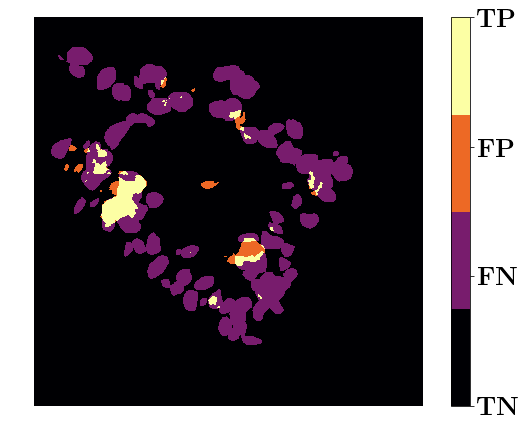

In [26]:
labels = [r'\textbf{TN}', r'\textbf{FN}', r'\textbf{FP}', r'\textbf{TP}']

plt.figure(figsize=(8, 6))
# use plt.cm.get_cmap(cmap, N) to get an N-bin version of cmap
plt.imshow(t, cmap=plt.cm.get_cmap('inferno', 4))
# This function formatter will replace integers with target names
formatter = plt.FuncFormatter(lambda val, loc: labels[val])
# We must be sure to specify the ticks matching our target names
cbar = plt.colorbar(ticks=[0, 1, 2, 3], format=formatter, ax=plt.gca())
cbar.ax.tick_params(labelsize=26)
plt.axis('off')
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)
plot_name = image_stem + '__' + model_stem + '__TP%d_FP%d_FN%d_IoU%.4f' % (TP, FP, FN, iou)
$plt.savefig(plot_name + '.eps', format='eps')
#plt.savefig('test_1.png', format='png')

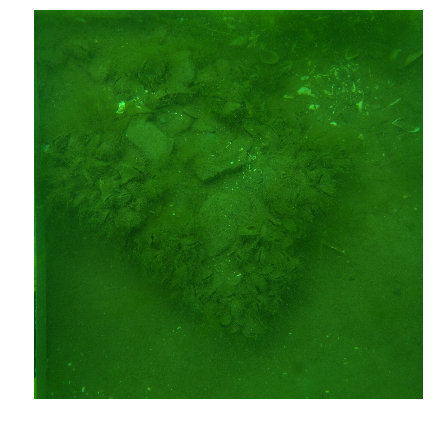

In [27]:
plt.figure(figsize=(8, 6))
# use plt.cm.get_cmap(cmap, N) to get an N-bin version of cmap
plt.imshow(img)
#plt.imshow(t, cmap=plt.cm.get_cmap('inferno', 4))
# This function formatter will replace integers with target names
#formatter = plt.FuncFormatter(lambda val, loc: labels[val])
# We must be sure to specify the ticks matching our target names
#cbar = plt.colorbar(ticks=[0, 1, 2, 3], format=formatter, ax=plt.gca())
#cbar.ax.tick_params(labelsize=fontsize)
plt.axis('off')
plt.subplots_adjust(left=left, right=right, bottom=bottom, top=top, wspace=wspace, hspace=hspace)
plot_name = image_stem
#plt.savefig(plot_name + '.jpg', format='jpeg')
#plt.savefig('test_2.png', format='png')

# Split up image into smaller chunks

In [28]:
#bgr_img.shape[0] // w_y

In [29]:
i = 1

scale_percent = 200

image_stem = jpeg_files[i].split('/')[-1].split('.')[0]
bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))
bgr_img = cv2.imread(osp.join(root_path, jpeg_files[i]))
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
imgc = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

composite_image = np.zeros((bgr_lab.shape[0], bgr_lab.shape[1]))

print(composite_image.shape)

w_y = 1500
w_x = 2000

for row in range(bgr_img.shape[0] // w_y):    
    for col in range(bgr_img.shape[1] // w_x):
        
        top = w_y * row
        bot = w_y * (row + 1)
        left  = w_x * col
        right = w_x * (col + 1)
        
        img = imgc[top:bot, left:right, :]
        lab = labc[top:bot, left:right]

        width = int(img.shape[0] * scale_percent / 100)
        height = int(img.shape[1] * scale_percent / 100)
        img = cv2.resize(img, (width, height)) # resize image
        lab = cv2.resize(lab, (width, height)) # resize image

        # pre-processing image consistent with PyTorch training transforms
        img = img / 255
        img = ((img - np.array([0.5, 0.5, 0.5])) / np.array([0.5, 0.5, 0.5]))
        imgt = torch.FloatTensor(img).to(device)
        imgt = imgt.unsqueeze(0)

        # Note: need to call contigious after the permute 
        # else max pooling will fail
        nchw_tensor = imgt.permute(0, 3, 1, 2).contiguous()

        with torch.no_grad():
            pred = sig(net(nchw_tensor))
        pred_np = pred.detach().cpu().numpy()

        # OpenCV loads the PNG mask as indexed color RGB, 
        # we need to convert it to a binary mask. 
        # The `0' in labc[:, :, 0] is the R channel.
        mask = np.zeros((lab.shape[0], lab.shape[1]), dtype='float32')
        mask[lab[:, :, 0] == 128] = 1

        pred_np = pred_np.squeeze()        
        width = int(img.shape[0] * 100 / scale_percent)
        height = int(img.shape[1] * 100 / scale_percent)
        pred_np_native = cv2.resize(pred_np, (width, height)) # resize image
        composite_image[top:bot, left:right] = pred_np_native * 255

IndexError: list index out of range

In [ ]:
plt.figure(figsize=(40.00, 30.00))
plt.imshow(composite_image)

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 1, figsize=(40.00, 30.00))
#p = (pred_np * 255).astype('uint8')
p = composite_image.astype('uint8')
src2 = np.zeros((p.shape[0], p.shape[1], 3), np.uint8)
src2[:, :, 2] = p
dst = cv2.addWeighted(imgc, 0.5, src2, 0.5, 0)
axes.imshow(dst)
axes.axis('off')
plt.tight_layout()

In [ ]:
pred = torch.FloatTensor((composite_image / 255)).to(device)

In [ ]:
mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1

targets = torch.LongTensor(mask)
targets = targets.to(device)

outputs = pred.squeeze(1).round().long()
intersection = (outputs & targets).float().sum((0, 1))
union = (outputs | targets).float().sum((0, 1))
iou = intersection / union
print(iou.item())

In [ ]:
bgr_lab = cv2.imread(osp.join(root_path, png_files[0]))
labc = cv2.cvtColor(bgr_lab, cv2.COLOR_BGR2RGB)
mask = np.zeros((labc.shape[0], labc.shape[1]), dtype='float32')
mask[labc[:, :, 0] == 128] = 1
targets = torch.LongTensor(mask)
targets = targets.to(device)

In [ ]:
#plt.imshow(img)